In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [2]:
train_df = os.listdir("D:/Python/pythonProject/pythonProject/ML/dog_vs_cat/train/train")
test_df = os.listdir("D:/Python/pythonProject/pythonProject/ML/dog_vs_cat/test1/test1")

In [10]:
filenames = os.listdir("D:/Python/pythonProject/pythonProject/ML/dog_vs_cat/train/train/")
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})
data.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [18]:
labels = data['label']

X_train, X_temp = train_test_split(data, test_size = 0.2, stratify=labels, random_state = 42)
label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size = 0.5, stratify = label_test_val, random_state = 42)

print("The shape of train data", X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


Data preparation

In [27]:
image_size = 128
image_channel = 3
bat_size = 32

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=15,
                                    horizontal_flip=True,zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)                                    

In [29]:
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = "D:/Python/pythonProject/pythonProject/ML/dog_vs_cat/train/train/",
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )

val_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = "D:/Python/pythonProject/pythonProject/ML/dog_vs_cat/train/train/",
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                ) 

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = "D:/Python/pythonProject/pythonProject/ML/dog_vs_cat/train/train/",
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )
                                                

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [34]:
train_gen = train_datagen.flow_from_directory("D:/Python/pythonProject/pythonProject/ML/dog_vs_cat/train/train/", 
                                              class_mode='binary',
                                              target_size = (image_size,image_size),
                                              batch_size = bat_size,
                                             )

val_gen = test_datagen.flow_from_directory("D:/Python/pythonProject/pythonProject/ML/dog_vs_cat/test1/test1/", 
                                          class_mode='binary',
                                          batch_size = bat_size,
                                          target_size = (image_size,image_size),
                                          shuffle = False
                                         )                                             

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [35]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)       

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

In [37]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [38]:
cat_dog = model.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = 30,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

Epoch 1/30


625/625 [==============================] - 478s 758ms/step - loss: 0.6440 - accuracy: 0.6708 - val_loss: 0.7452 - val_accuracy: 0.6352 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 447s 715ms/step - loss: 0.5026 - accuracy: 0.7595 - val_loss: 0.4705 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 428s 685ms/step - loss: 0.4263 - accuracy: 0.8018 - val_loss: 0.5049 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.8329
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 [==============================] - 351s 562ms/step - loss: 0.3750 - accuracy: 0.8329 - val_loss: 0.4659 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 328s 526ms/step - loss: 0.3153 - accuracy: 0.8608 - val_loss: 0.2651 - val_accuracy: 0.8872 - lr: 5.0000e-04
Epoch 6/30
625/625 [==================

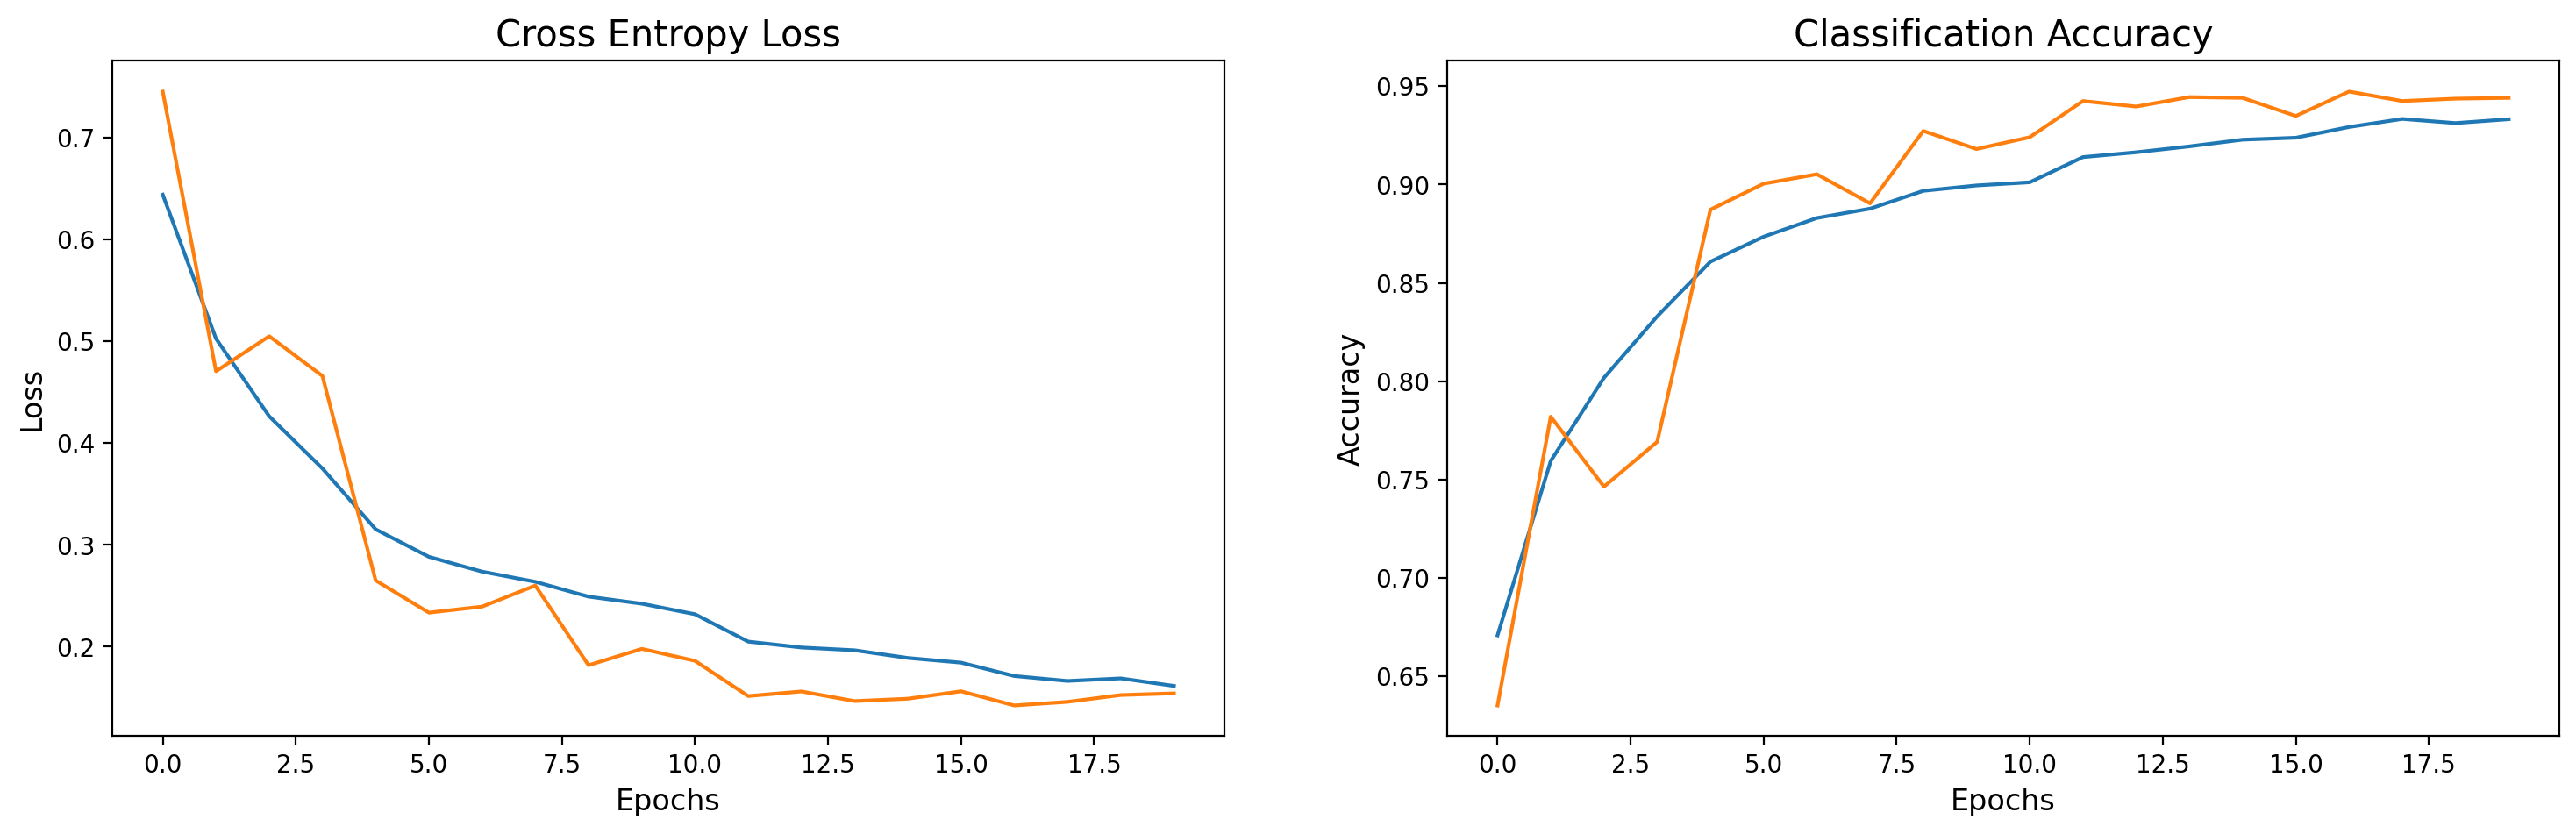

In [46]:
error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()


In [ ]:
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

In [47]:
model.save("model.h5")

D:\Python\pythonProject\pythonProject\ML\Brain tumer detection\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

In [51]:
y_pred = np.argmax(result, axis = 1)

In [52]:
y_true = test_generator.labels

In [53]:
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

In [55]:
print('The accuracy of the model for testing data is:',acc*100)

The accuracy of the model for testing data is: 94.59999799728394


In [54]:
print('The Loss of the model for testing data is:',loss)

The Loss of the model for testing data is: 0.13492019474506378
